In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imshow, imread
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.initializers import RandomNormal
from keras import backend as K

# Iceberg & Ships Images

## Load Data

In [2]:
labels = ['Ship','Iceberg']

In [3]:
npz = np.load('../Datasets/IcebergsShips/input_data.npz')

X_train = npz['X_train']
Y_train = npz['Y_train']
X_val = npz['X_validation']
Y_val = npz['Y_validation']

del npz

print ('We have {} examples to train'.format(Y_train.shape[0]))
print ('We have {} examples to validate'.format(Y_val.shape[0]))

We have 4113 examples to train
We have 100 examples to validate


### See Examples

#### Train

In [4]:
X_train.shape

(4113, 75, 75, 3)

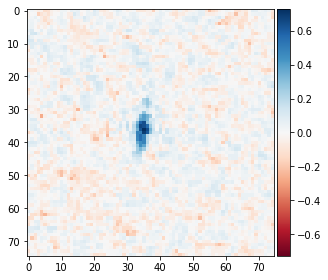

This is: Ship


In [5]:
ix = 0
imshow(X_train[ix, :, :, 0])
plt.show()
print ('This is:', labels[int(Y_train[ix])])

#### Validation

In [6]:
X_val.shape

(100, 75, 75, 3)

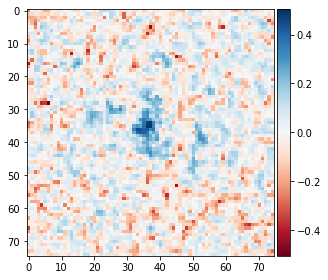

This is: Iceberg


In [7]:
ix = 0
imshow(X_val[ix, :, :, 0])
plt.show()
print ('This is:', labels[int(Y_val[ix])])

## Define Model

In [8]:
def get_siamese_model(input_shape):
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
        
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(filters=5, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=5, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=7, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=7, kernel_size=(2, 2), activation='relu'))
    model.add(Flatten())
    model.add(Dense(18, activation='sigmoid'))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation='sigmoid', bias_initializer=RandomNormal(mean=0.5, stddev=1e-2))(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    
    # return the model
    return siamese_net

In [9]:
model = get_siamese_model(X_train.shape[1:])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 18)           6912        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 18)           0           sequential[0][0]      

In [10]:
optimizer = Adam(lr=0.001, decay=2.5e-4)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

## Train

In [11]:
def generate_dataset(X, Y, pairs=5):
    # First let's separate the dataset from 1 matrix to a list of matricies
    images_list = np.split(X, len(X))
    labels_list = np.split(Y, len(Y))

    left_inputs = []
    right_inputs = []
    targets = []

    # Let's create the new dataset to train on
    for i in range(len(labels_list)):
        for _ in range(pairs):
            compare_to = i
            while compare_to == i: # Make sure it's not comparing to itself
                compare_to = random.randint(0, len(Y)-1)

            left_inputs.append(images_list[i])
            right_inputs.append(images_list[compare_to])

            if labels_list[i] == labels_list[compare_to]:
                targets.append(1.)
            else:
                targets.append(0.)
                
    left_inputs = np.squeeze(np.array(left_inputs))
    right_inputs = np.squeeze(np.array(right_inputs))
    targets = np.squeeze(np.array(targets))
    
    return left_inputs, right_inputs, targets

In [12]:
train_left_inputs, train_right_inputs, train_targets = generate_dataset(X_train, Y_train, pairs=5)
val_left_inputs, val_right_inputs, val_targets = generate_dataset(X_val, Y_val, pairs=5)

In [13]:
model.fit([train_left_inputs, train_right_inputs], train_targets,
          batch_size=16,
          epochs=30,
          verbose=1,
          validation_data=([val_left_inputs, val_right_inputs], val_targets))

Epoch 1/30
1286/1286 [==============================] - 50s 39ms/step - loss: 0.6238 - accuracy: 0.6625 - val_loss: 0.5406 - val_accuracy: 0.7520
Epoch 2/30
1286/1286 [==============================] - 46s 36ms/step - loss: 0.5348 - accuracy: 0.7414 - val_loss: 0.4642 - val_accuracy: 0.8000
Epoch 3/30
1286/1286 [==============================] - 58s 45ms/step - loss: 0.4901 - accuracy: 0.7720 - val_loss: 0.4486 - val_accuracy: 0.8140
Epoch 4/30
1286/1286 [==============================] - 50s 39ms/step - loss: 0.4677 - accuracy: 0.7836 - val_loss: 0.4184 - val_accuracy: 0.8200
Epoch 5/30
1286/1286 [==============================] - 52s 41ms/step - loss: 0.4493 - accuracy: 0.7969 - val_loss: 0.4135 - val_accuracy: 0.8380
Epoch 6/30
1286/1286 [==============================] - 54s 42ms/step - loss: 0.4350 - accuracy: 0.8055 - val_loss: 0.4500 - val_accuracy: 0.8180
Epoch 7/30
1286/1286 [==============================] - 49s 38ms/step - loss: 0.4225 - accuracy: 0.8127 - val_loss: 0.4157 -

Done!